<a href="https://colab.research.google.com/github/estheroratemstet/Project_mask/blob/main/Research/Image%20Classification/White%20Box%20Evasion%20Attacks/Notebooks/Image_Attack_Face_Recognize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Face Recognition Attack 
In this notebook we would like to attack a classifier<br>
The classifier identifies faces
The notebook is based on https://colab.research.google.com/drive/15scoLI7JwizNphXC_3e6G8N8Vvw2qQos?authuser=2     from it the model is loaded


The attack based on https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/attack_defence_imagenet.ipynb

In this notebook we show:


*   Applying both targeted and untargeted attacks
*   Deploying defences against such attacks
*   Creating adversarial samples that can bypass those defences





## Load prerequisites


In [ ]:
! pip install adversarial-robustness-toolbox==1.5.2
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.preprocessor import SpatialSmoothing
from art.utils import to_categorical
import tensorflow as tf
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.models import load_model
from matplotlib import pyplot as plt
import numpy as np
import os
import random

## Load Face Recognize classifier

In [ ]:
model=load_model("/content/drive/MyDrive/DEEP KEEP TASKS/27-06/DATASET_FACE_RECOGNITION/Model/FaceRecognitionModel.hdf5")

## Load image

We are going to load one image from test set of a category that wiil be chosen

In [ ]:
i=0
image_paths=[]
dir_path='/content/drive/MyDrive/DEEP KEEP TASKS/27-06/DATASET_FACE_RECOGNITION/Model_Data/Test'
classes=['akira Isabel Mebarak', 'anda Crew', 'bert Downey Jr', 'ernen shipka', 'phie Turner', 'ristian Bale', 'tharine Mcphee']
num_classes=len(classes)
print("The Labels")
for label in classes:
  print(i, label)
  i +=1
index=int(input("Enter Number between 0-6:"))
image_label=classes[index]
dir_path_pins=os.path.join(dir_path,image_label)
for path_img in os.listdir(dir_path_pins):
  image_paths.append(os.path.join(dir_path_pins,path_img))
path=random.sample(image_paths,1)
image_paths=[]
path=path[0]


The Labels
0 akira Isabel Mebarak
1 anda Crew
2 bert Downey Jr
3 ernen shipka
4 phie Turner
5 ristian Bale
6 tharine Mcphee
Enter Number between 0-6:5


In [ ]:
def num_to_label(num):
  return classes[num]

##Predict One Image

Let's look at the prediction that this model yields for the selected image:

prediction: 5 ristian Bale


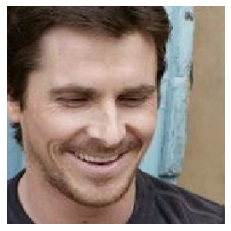

In [ ]:
img= image.load_img(path, target_size=(256,256,3))
plt.imshow(img)
plt.axis("off")
i = image.img_to_array(img)
i=preprocess_input(i)
input_arr = np.array([i])
pred= np.argmax(model.predict(input_arr))
print("prediction:",pred,num_to_label(pred))


Next we are going to use a state-of-the-art classifier on those images.<br>
We will also create an ART KerasClassifier wrapper around the model.

In [ ]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
classifier = KerasClassifier(clip_values=(0, 255), model=model)

Now we will apply the classifier object to obtain the prediction.

In [ ]:
# Then apply the model through the classifier API, determine the predicted label and confidence:
x_art=input_arr
arr = classifier.predict(x_art)
pred=np.argmax(arr)
confidence = arr[0][pred]
label=num_to_label(pred)
print('Prediction:',label, '- confidence {0:.2f}'.format(confidence))

Prediction: ristian Bale - confidence 1.00


So through the classifier API we obtain the same predictions as from the raw model, but now we have an abstraction from the actual backend (e.g. Keras).

The classifier wrapper allows us to call other functions besides predict.

For example, we can obtain the **loss gradient** of the classifier, which is used in many of the algorithms for adversarial sample generation:

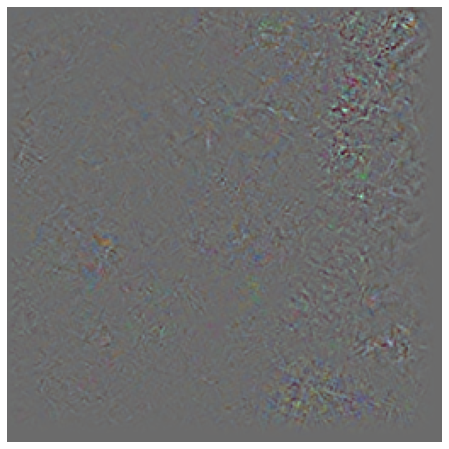

In [ ]:
loss_gradient = classifier.loss_gradient(x=x_art, y=to_categorical([index], nb_classes=num_classes))

# Let's plot the loss gradient. 
# First, swap color channels back to RGB order:
loss_gradient_plot = loss_gradient[0][..., ::-1] 

# Then normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Show plot:
plt.figure(figsize=(8,8)); plt.imshow(loss_gradient_plot); plt.axis('off'); plt.show()

## Create adversarial samples

Next, we are going to create an adversarial sample. <br>
We are going to use **Projected Gradient Descent (PGD)**, which is one of the strongest existing attacks. <br>
We will  perform an **untargeted** and **targeted** adversarial attack.

### untargeted adversarial attack

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


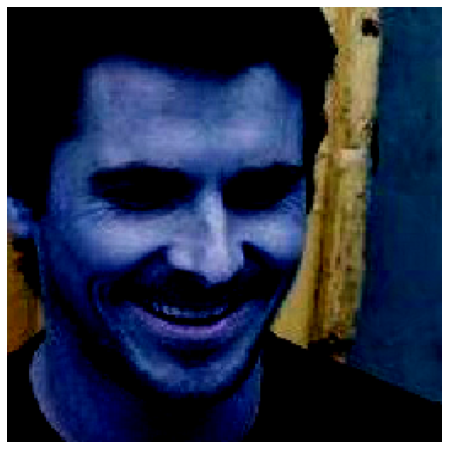

Prediction: anda Crew 1 - confidence 1.00


In [ ]:
# Create the attacker:
adv = ProjectedGradientDescent(classifier, targeted=False, max_iter=10, eps_step=0.001, eps=0.01)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0][..., ::-1] ); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:',num_to_label(label_adv), label_adv, '- confidence {0:.2f}'.format(confidence_adv))

### targeted adversarial attack

Now, we perform a **targeted attack** where we pick the class that we want the classifier to predict on the adversarial sample. <br>
Below is the list of labels and class names - make your pick!

In [ ]:
print("The Labels")
i=0
for label in classes:
  print(i, label)
  i +=1
index=int(input("Enter Number between 0-6 for a target attack: "))

The Labels
0 akira Isabel Mebarak
1 anda Crew
2 bert Downey Jr
3 ernen shipka
4 phie Turner
5 ristian Bale
6 tharine Mcphee
Enter Number between 0-6 for a target attack: 3


Now let's perform the targeted attack:

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


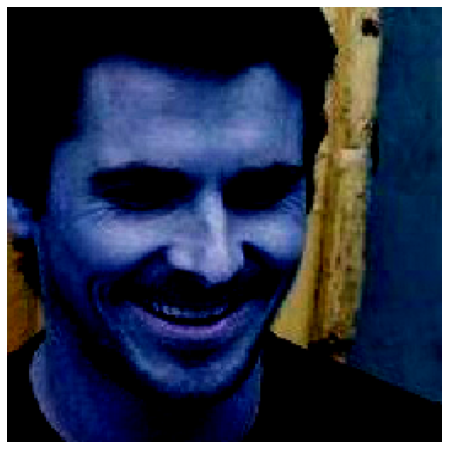

Prediction: ernen shipka 3 - confidence 1.00


In [ ]:
# Set the configuration to a targeted attack:
adv.set_params(targeted=True)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art, y=to_categorical([index], nb_classes=num_classes))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0][..., ::-1]); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:',num_to_label(label_adv), label_adv, '- confidence {0:.2f}'.format(confidence_adv))

We can measure the quantity of perturbation that was added to the image using different $\ell_p$ norms. <br>
**Note:** the PGD attack controls the $\ell_\infty$ norm via the `epsilon` parameter.

Perturbation l_0 norm: 1%
Perturbation l_1 norm: 2%
Perturbation l_2 norm: 2%
Noise l_inf norm: 1%


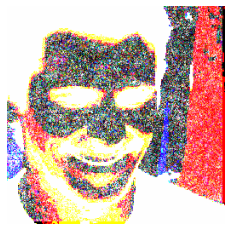

In [ ]:
l_0 = int(99*len(np.where(np.abs(x_art[0] - x_art_adv[0])>0.5)[0]) / (256*256*3)) + 1   
l_1 = int(99*np.sum(np.abs(x_art[0] - x_art_adv[0])) / np.sum(np.abs(x_art[0]))) + 1
l_2 = int(99*np.linalg.norm(x_art[0] - x_art_adv[0]) / np.linalg.norm(x_art[0])) + 1 
l_inf = int(99*np.max(np.abs(x_art[0] - x_art_adv[0]))) + 1

print('Perturbation l_0 norm: %d%%' % l_0)
print('Perturbation l_1 norm: %d%%' % l_1)
print('Perturbation l_2 norm: %d%%' % l_2)
print('Noise l_inf norm: %d%%' % l_inf)

# Let's also plot the absolute amount of adversarial pixel perturbations:
pert = np.abs(x_art[0] - x_art_adv[0])[..., ::-1]
pert_min = np.min(pert)
pert_max = np.max(pert)
plt.figure(figsize=(4,4)); plt.imshow((pert - pert_min) / (pert_max - pert_min)); plt.axis('off'); plt.show()

## Apply defences
Next we are going to apply a simple input preprocessing defence: Spatial Smoothing.

Ideally, we want this defence to result in correct predictions when applied both to the original and the adversarial images.

[[2.1302740e-19 5.2801599e-05 2.3521777e-07 7.4546933e-13 4.8697569e-12
  9.9994695e-01 1.4773642e-14]] 5 0.99994695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[1.3386915e-14 3.3811835e-04 2.4326730e-06 2.0338588e-05 9.5292005e-09
  9.9963903e-01 4.4063014e-11]] 5 0.99963903
Prediction of original sample: 5 ristian Bale - confidence 1.00
Prediction of adversarial sample: 5 ristian Bale - confidence 1.00


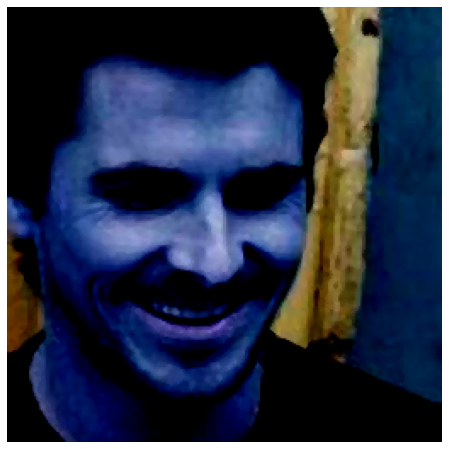

In [ ]:
# Initalize the SpatialSmoothing defence. 
ss = SpatialSmoothing(window_size=3)

# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def, _ = ss(x_art)
x_art_adv_def, _ = ss(x_art_adv)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]
print(pred_def,label_def,confidence_def)

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]
print(pred_adv_def,label_adv_def,confidence_adv_def)
# Print the predictions:
print('Prediction of original sample:',label_def,  num_to_label(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:',label_adv_def,  num_to_label(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))

# Show the preprocessed adversarial sample:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] ); plt.axis('off'); plt.show()

## Perform adaptive whitebox attack to defeat defences

Next we are going to mount an adaptive whitebox attack in which the attacker aims at defeating the defence that we just put into place.

First, we create a classifier which incorporates the defence:

In [ ]:
classifier_def = KerasClassifier(preprocessing_defences=[ss], clip_values=(0, 255), 
                                 model=model)

# Now we apply this classifier to the adversarial sample from before:
pred_def = classifier_def.predict(x_art_adv)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

print('Prediction:', num_to_label(label_def), label_def, '- confidence {0:.2f}'.format(confidence_def))

Prediction: ristian Bale 5 - confidence 1.00


We observe that this classifier reproduces the prediction that we had obtained before by manually applying the input preprocessing defence.

Now we create an adversarial sample against the *defended* classifier. <br>
As we are going to see, this adversarial sample is able to bypass the input preprocessing defence.

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


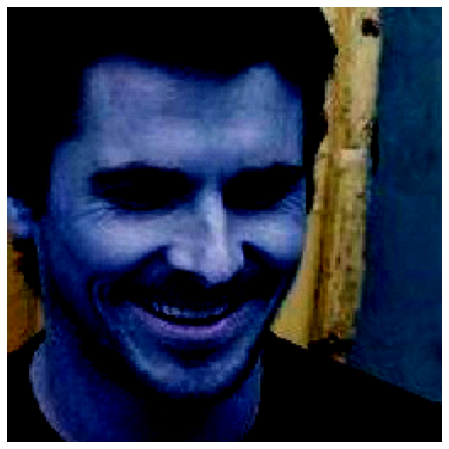

Prediction: 3 ernen shipka - confidence 1.00


In [ ]:
# Create the attacker.
# Note: here we are using a stronger attack (larger number of iterations) in order to defeat the defence
adv_def = ProjectedGradientDescent(classifier_def, targeted=True, max_iter=40, eps_step=0.001, eps=0.01)

# Generate the adversarial sample:
x_art_adv_def = adv_def.generate(x_art,y=to_categorical([index], nb_classes=num_classes))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1]); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier_def.predict(x_art_adv_def)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:',label_adv, num_to_label(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

Let's also look at the $\ell_p$ norms of that adversarial perturbation:

In [ ]:
l_0 = int(99*len(np.where(np.abs(x_art[0] - x_art_adv_def[0])>0.5)[0]) / (224*224*3)) + 1   
l_1 = int(99*np.sum(np.abs(x_art[0] - x_art_adv_def[0])) / np.sum(np.abs(x_art[0]))) + 1
l_2 = int(99*np.linalg.norm(x_art[0] - x_art_adv_def[0]) / np.linalg.norm(x_art[0])) + 1 
l_inf = int(99*np.max(np.abs(x_art[0] - x_art_adv_def[0])) / 255) + 1

print('Perturbation l_0 norm: %d%%' % l_0)
print('Perturbation l_1 norm: %d%%' % l_1)
print('Perturbation l_2 norm: %d%%' % l_2)
print('Noise l_inf norm: %d%%' % l_inf)

Perturbation l_0 norm: 1%
Perturbation l_1 norm: 3%
Perturbation l_2 norm: 3%
Noise l_inf norm: 1%


Comparing with the previous adversarial sample, the $\ell_0$ and $\ell_1$ norms have slightly increased, while $\ell_2$ and $\ell_\infty$ norms have stayed the same (the latter not being surprising as the PGD attack controls the $\ell_\infty$ norm budget).